<a href="https://colab.research.google.com/github/HimanshuVerma9760/Deep-Learning-Based-Medical-Image-Segmentation-for-Disease-Diagnosis/blob/main/Deep_Learning_Based_Medical_Image_Segmentation_for_Disease_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/scl/fi/i72w52yk9pzcgg0hclouq/brain_tumor_dataset.zip?rlkey=sp3t9b3zy7y8k0e4gqc4jfuw6&dl=0

In [ ]:
!unzip /content/brain_tumor_dataset.zip?rlkey=sp3t9b3zy7y8k0e4gqc4jfuw6

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import keras
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import matplotlib.patches as patches


In [5]:
ROOT_DIR = "/content/brain_tumor_dataset"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [6]:
number_of_images.items()

dict_items([('Healthy', 1693), ('Tumor', 2815)])

Now we will use the Data such that:
* 70% of it will be used for Training
* 15% of it will be used for Validation &
* 15% for Testing

In [7]:
# Splitting data into train, validation, and test sets
def dataFolder(p, split):
    if not os.path.exists("./"+p):
        os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
        os.makedirs("./"+p+"/" + dir, exist_ok=True)

        population = os.listdir(os.path.join(ROOT_DIR, dir))
        sample_size = math.floor(split * number_of_images[dir]) - 5
        sample_size = min(sample_size, len(population))

        selected_samples = np.random.choice(population, size=sample_size, replace=False)
        for img in selected_samples:
            O = os.path.join(ROOT_DIR, dir, img)
            D = os.path.join("./"+p, dir)
            shutil.copy(O, D)
            os.remove(O)

In [8]:
dataFolder("train", 0.7)

In [9]:
dataFolder("val", 0.15)

In [10]:
dataFolder("test", 0.15)

BUILDING OUR MODEL

In [11]:
# CNN Model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(filters=36, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 36)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [12]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

Preparing Our Data Using Image Generator

In [13]:
def preprocessingImages(path, zoom_range=0.2, shear_range=0.2, rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True):
    image_data = ImageDataGenerator(
        zoom_range=zoom_range,
        shear_range=shear_range,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        rescale=1/255,
        horizontal_flip=horizontal_flip,
        fill_mode='nearest'
    )
    image_generator = image_data.flow_from_directory(
        directory=path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary'
    )
    return image_generator


In [14]:
train_data = preprocessingImages("/content/train")


Found 3145 images belonging to 2 classes.


In [15]:
test_data = preprocessingImages("/content/test", zoom_range=0, shear_range=0, horizontal_flip=False)

Found 665 images belonging to 2 classes.


In [16]:
val_data = preprocessingImages("/content/val", zoom_range=0, shear_range=0, horizontal_flip=False)

Found 665 images belonging to 2 classes.


In [17]:
# Early Stopping & Model Checkpoint
es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=5, verbose=1, mode='auto')
mc = ModelCheckpoint(filepath="./bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode='auto')
cd = [es, mc]

**MODEL TRAINING**

In [18]:
# Model Training
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=30,
    verbose=1,
    validation_data=val_data,
    validation_steps=len(val_data),
    callbacks=cd
)

Epoch 1/30
99/99 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.7768
Epoch 1: val_accuracy improved from -inf to 0.88722, saving model to ./bestmodel.h5
99/99 [==============================] - 78s 668ms/step - loss: 0.5012 - accuracy: 0.7768 - val_loss: 0.2859 - val_accuracy: 0.8872
Epoch 2/30
99/99 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8820
Epoch 2: val_accuracy improved from 0.88722 to 0.90376, saving model to ./bestmodel.h5
99/99 [==============================] - 55s 554ms/step - loss: 0.3142 - accuracy: 0.8820 - val_loss: 0.2489 - val_accuracy: 0.9038
Epoch 3/30
99/99 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.8706
Epoch 3: val_accuracy improved from 0.90376 to 0.91729, saving model to ./bestmodel.h5
99/99 [==============================] - 55s 558ms/step - loss: 0.3054 - accuracy: 0.8706 - val_loss: 0.2434 - val_accuracy: 0.9173
Epoch 4/30
99/99 [==============================] - ETA: 0s - lo

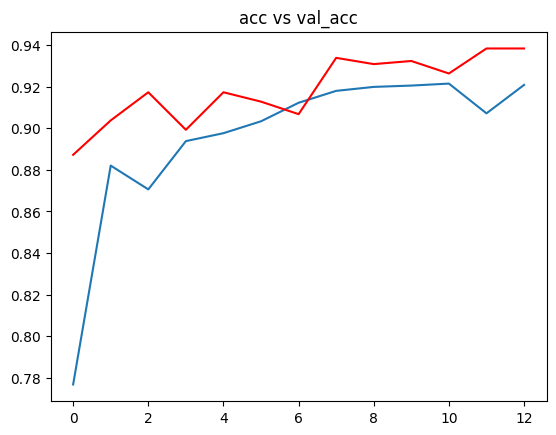

In [19]:
# Plotting the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], c="red")
plt.title("acc vs val_acc")
plt.show()

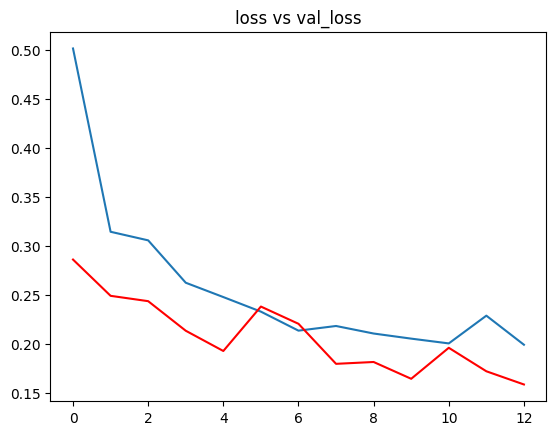

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], c="red")
plt.title("loss vs val_loss")
plt.show()

In [21]:
# Loading the best model
best_model = load_model("./bestmodel.h5")

**Model Accuracy**

In [22]:
# Model Evaluation
loss, acc = best_model.evaluate(test_data)
print(f"Test accuracy: {acc*100:.2f}%")

21/21 [==============================] - 9s 423ms/step - loss: 0.1890 - accuracy: 0.9248
Test accuracy: 92.48%


In [36]:
# Predicting on a single image
path_to_image = "/content/brain_tumor_dataset/Tumor/Tr-me_0970.jpg"
img = keras.preprocessing.image.load_img(path_to_image, target_size=(224, 224))
input_arr = keras.preprocessing.image.img_to_array(img) / 255.0
input_arr = np.expand_dims(input_arr, axis=0)

preds = best_model.predict(input_arr)
pred_class = "Tumor" if preds[0][0] > 0.5 else "No Tumor"
print("Predicted class:", pred_class)

1/1 [==============================] - 0s 19ms/step
Predicted class: Tumor


1/1 [==============================] - 0s 18ms/step


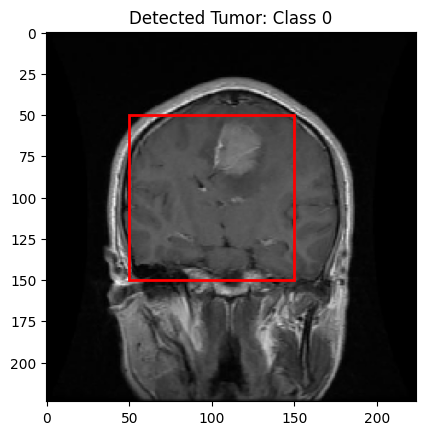

In [37]:
def visualize_tumor_detection(model, image_path):
    # Load the image
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the tumor using the model
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction[0])

    # Visualize the image with the bounding box around the detected tumor
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Assuming 'bbox' contains the bounding box coordinates (x1, y1, x2, y2)
    bbox = [50, 50, 150, 150]  # Example bounding box coordinates

    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.title(f'Detected Tumor: Class {pred_class}')
    plt.show()

# Example usage
# Replace 'path_to_model.h5' with the path to your trained model
# Replace 'path_to_image.jpg' with the path to the image you want to visualize
model = best_model  # Load your trained model
image_path = path_to_image # Path to the image
visualize_tumor_detection(model, image_path)
